# HW3

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import pickle
from matplotlib import pyplot as plt

## Task 1: Framework

PyTorch is the frame work I will be using for this project. It is chosen because of it's simplicity (declarative layers) while also giving the developer very low level control of the underlying data (gradients, bias, etc...). Also PyTorch offers a OOP model approach for developers to package individual models as a class and re-use them in the future. 

Here are some important modules to implement this 2 layer Neural Network

- **nn.Linear**
    - Defines a fully connected layer, which is the most basic component of a neural network.
    - https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=nn%20linear#torch.nn.Linear
- **nn.Module**
    - Base class of all neural networks for the PyTorch framework.
    - https://pytorch.org/docs/stable/generated/torch.nn.Module.html#torch.nn.Module
- **optim.Adam**
    - Adam optimizer, which is a modified gradient descent with variable learning rate.
    - https://pytorch.org/docs/stable/generated/torch.optim.Adam.html?highlight=adam#torch.optim.Adam
- **functional.cross_entropy**
    - Cross entropy loss function. Used for calculating the loss of the classification problem, and also serves as the entry point for calculating gradient and doing back propagation.
    - https://pytorch.org/docs/stable/generated/torch.nn.functional.cross_entropy.html?highlight=cross_entropy#torch.nn.functional.cross_entropy

## Task 2: Implementation

**Dataset**

The dataset of choice is CIFAR-10, which consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. The 10 labels are 
1. airplane										
1. automobile										
1. bird										
1. cat										
1. deer										
1. dog										
1. frog										
1. horse										
1. ship										
1. truck

**Load dataset**

In [83]:
class CIFAR_10(Dataset):
    '''
    CIFAR 10 dataset
    '''
    def __init__(self, filenames):
        self.filenames = filenames
        # read in dataset
        self.data = []
        self.labels = []
        for filename in self.filenames:
            raw = self.unpickle(filename)
            self.data.append(raw[b'data'])
            self.labels.append(raw[b'labels'])
        # concat into torch tensors
        self.data = torch.cat([torch.tensor(x, dtype=torch.float64) for x in self.data])
        self.labels = torch.cat([torch.tensor(x, dtype=torch.uint8) for x in self.labels])
        # normalize dataset
        self.data /= 255
    
    def unpickle(self, file):
        with open(file, 'rb') as fo:
            data = pickle.load(fo, encoding='bytes')
        return data

    def __len__(self):
        return self.labels.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]
        

Load train, valid, and test dataset

In [84]:
train_dataset = CIFAR_10([f'../data/CIFAR_10/cifar-10-batches-py/data_batch_{i}' for i in range(1, 5)])
valid_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/data_batch_5'])
test_dataset = CIFAR_10(['../data/CIFAR_10/cifar-10-batches-py/test_batch'])

Load label names

In [46]:
meta = None
with open('../data/CIFAR_10/cifar-10-batches-py/batches.meta', 'rb') as fo:
    meta = pickle.load(fo, encoding='bytes')

**Sample data visualization**

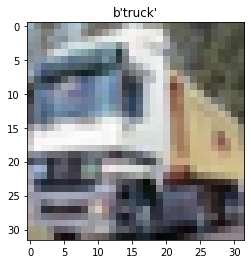

In [50]:
img, lbl = train_dataset.__getitem__(1)
img = torch.moveaxis((img.reshape((3, 32, 32)) * 255).long(), 0, -1)
plt.title(meta[b'label_names'][lbl])
plt.imshow(img)

**Train/Dev/Test Split**

The CIFAR-10 dataset was pre-splitted into 5 training batches and 1 testing batches, with each batches containing 10000 entries. For this project I will use the one of the 5 training batches as the dev/validation dataset.

**Final cost function**

Since it is a multiple label classification problem, cross entropy loss is used. The resulting value from the neural network is first passed into a softmax function before being passed into cross entropy. Final cost looks like below:

$$
CE_{loss} = - \sum^C_i t_i \log(\frac{e^{s_i}}{\sum^C_j e^{s_j}})
$$

**Model implementation**

In [179]:
class MLP(nn.Module):
    def __init__(self, h1_size = 128, h2_size = 64):
        '''
        Simple DNN with 2 layers of CNN followed by 3 linear layers
        '''
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 4)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 12, 4)
        self.flatten = nn.Flatten()
        self.f1 = nn.Linear(12 * 11 * 11, h1_size)
        self.f2 = nn.Linear(h1_size, h2_size)
        self.drop1 = nn.Dropout()
        self.f3 = nn.Linear(h2_size, 10)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.flatten(x)
        x = self.f1(x)
        x = F.relu(x)
        x = self.f2(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.f3(x)
        return x

Hyper parameter configuration

In [171]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'

batch_size = 512
epochs = 30
learning_rate = 0.001

model = MLP(h1_size = 128, h2_size = 64)
model.to(device)
model.train()

MLP(
  (conv1): Conv2d(3, 6, kernel_size=(4, 4), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 12, kernel_size=(4, 4), stride=(1, 1))
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (f1): Linear(in_features=1452, out_features=128, bias=True)
  (f2): Linear(in_features=128, out_features=64, bias=True)
  (drop1): Dropout(p=0.5, inplace=False)
  (f3): Linear(in_features=64, out_features=10, bias=True)
)

Spawn dataloaders

In [168]:
train_loader = DataLoader(dataset = train_dataset, batch_size = batch_size)
valid_loader = DataLoader(dataset = valid_dataset, batch_size = batch_size)
test_loader = DataLoader(dataset = test_dataset, batch_size = batch_size)
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

**Training**

In [164]:
for epoch in range(epochs):
    sum_loss = 0
    for (data, labels) in tqdm(train_loader):
        
        # zero out gradient
        optimizer.zero_grad()
        
        # send batch to device
        data, labels = data.to(device), labels.to(device)
       
        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())
        
        # cross entropy loss
        loss = F.cross_entropy(pred, labels)
        
        # back propagation
        loss.backward()
        sum_loss += loss.item()
        optimizer.step()
    
    # print out epoch stats
    print(f'Epoch {epoch}, train loss: {sum_loss / batch_size}')

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.18it/s]


Epoch 0, train loss: 0.32328672893345356


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 78.06it/s]


Epoch 1, train loss: 0.2848415777552873


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.68it/s]


Epoch 2, train loss: 0.26577356993220747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.66it/s]


Epoch 3, train loss: 0.25555909634567797


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.83it/s]


Epoch 4, train loss: 0.2479245278518647


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch 5, train loss: 0.24072468606755137


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.60it/s]


Epoch 6, train loss: 0.23492203536443412


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.88it/s]


Epoch 7, train loss: 0.22935114218853414


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 67.75it/s]


Epoch 8, train loss: 0.2243683929555118


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 72.21it/s]


Epoch 9, train loss: 0.21925282129086554


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.81it/s]


Epoch 10, train loss: 0.21452953317202628


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.74it/s]


Epoch 11, train loss: 0.20950802671723068


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.11it/s]


Epoch 12, train loss: 0.20513562485575676


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 75.67it/s]


Epoch 13, train loss: 0.2023393149720505


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.70it/s]


Epoch 14, train loss: 0.19927469512913376


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.04it/s]


Epoch 15, train loss: 0.19459954975172877


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.22it/s]


Epoch 16, train loss: 0.19172520632855594


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.00it/s]


Epoch 17, train loss: 0.1872442023595795


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.00it/s]


Epoch 18, train loss: 0.18510092434007674


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.07it/s]


Epoch 19, train loss: 0.1818123406264931


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 70.54it/s]


Epoch 20, train loss: 0.17789803782943636


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 76.92it/s]


Epoch 21, train loss: 0.17464986315462738


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.76it/s]


Epoch 22, train loss: 0.17188518366310745


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch 23, train loss: 0.17025469965301454


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 74.88it/s]


Epoch 24, train loss: 0.16870393813587725


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.45it/s]


Epoch 25, train loss: 0.1672387425787747


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.30it/s]


Epoch 26, train loss: 0.16577990393852815


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.60it/s]


Epoch 27, train loss: 0.16151188872754574


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 71.43it/s]


Epoch 28, train loss: 0.15941607189597562


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:01<00:00, 77.15it/s]

Epoch 29, train loss: 0.15531852294225246


**Evaluation**

Training and Validation Accuracy

In [167]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(train_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Training Accuracy: {correct / len(train_dataset):.3f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 79/79 [00:00<00:00, 115.67it/s]

Training Accuracy: 0.697


In [166]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(valid_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Validation Accuracy: {correct / len(valid_dataset):.3f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 119.73it/s]

Validation Accuracy: 0.585


Testing Accuracy (Only ran after tuning hyper-parameters using validation dataset)

In [169]:
model.eval()
with torch.no_grad():
    correct = 0
    for (data, labels) in tqdm(test_loader):

        # send batch to device
        data, labels = data.to(device), labels.to(device)

        # foward pass
        pred = model(data.view(labels.shape[0], 3, 32, 32).float())

        # softmax and argmax
        pred = F.softmax(pred, dim = 1)
        pred = torch.argmax(pred, dim = 1)

        # compute accuracy
        correct += torch.sum(pred == labels.float())

# accuracy
print(f'Testing Accuracy: {correct / len(test_dataset):.3f}')

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 111.03it/s]

Testing Accuracy: 0.583


## Task 3: Hyper-parameter tuning

The hyper-parameters I'm intersted in tuning are the following:
1. Number of epochs
1. Batch size
1. Learning rate
1. Hidden layer 1 size
1. Hidden layer 2 size

The technique I used is the "grid search" method. Basically, For each hyper-parameters above I have a set range of possible values. I then train a neural networks for every possible combinations of the hyper-parameters above, and pick the model with the best validation accuracy. The idea is that given a carefully selected range of reasonable values, I can brute-force out the best combination of the above hyper-parameters.

For regularization I implemented a dropout layer with probability 0.5. This is because I start to notice some degree of overfitting (training loss is going down while validation loss isn't) when training the model to higher epochs. Using this technique significantly generalized the model and also boosted my validation accuracy. 

For optimization, I used the Adam optimizer. This is to prevent the gradient being stuck at a local minima by changing the learning rate using exponential moving accuracy. Generally, using Adam optimzer allows the model to converge faster.

##  Task 4: Non-neural-network model

In [184]:
from sklearn.tree import DecisionTreeClassifier

**Train a Decision Tree**

In [178]:
clf = DecisionTreeClassifier()
clf.fit(train_dataset.data, train_dataset.labels)

DecisionTreeClassifier()

Testing accuracy

In [188]:
print(f'Testing Accuracy: {clf.score(test_dataset.data, test_dataset.labels):.3f}')

Testing Accuracy: 0.264


**Comparison**

The DNN we trained has a test accuracy of 0.583, while the decision tree has less than half of that (0.264). While both model performs better than random guesses (0.1 accuracy), there exists a huge gap between the DNN and the Decision Tree. Here are some reasons to explain the difference in performance between the two model:

- The curse of dimensionality: There are simply way too many dimensions (3072 features) for the tree to make any meaningful cuts, since on high dimensionality, a lot of unrelated data looks similar. On the other hand, the DNN we trained compresses the data with 2 layers of CNN, before being passed into 2 more hidden layers to compute the decision, which allows for efficient feature extraction. 

- Overfitting: The decision tree is most definitely overfitting the training data, which impact its performance when evaluating on a dataset that it has not seen before. 

- Learning capability: Decision tree is more of an art than science. Unlike a neural network, it does not have the ability to learn and extract features such as a wing on a plane or a wheel on a truck. It simply computes the best dimension to cut that results in the highest information gain.